# Risk Contributions and Risk Parity

> The word 'risk' derives from the early Italian risicare, which means 'to dare'. In this sense, risk is a choice rather than a fate. The actions we dare to take, which depend on how free we are to make choices, are what the story of risk is all about.

_Peter L. Bernstein, Against the Gods: The Remarkable Story of Risk_

In [1]:
# used during development to releoad modules every time there is a change
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from numpy.linalg import inv

import statsmodels.api as sm
from course_1.risk_kit import Metrics
import nb.edhec_risk_kit_206 as erk
from backtesting import Backtester, EquallyWeighted, CapWeighted,\
GlobalMiminumVariance, EqualRiskContribution

import ipywidgets as widgets
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.options.display.float_format = '{:.6f}'.format

m= Metrics()

In [2]:
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

rets = ind_rets["2013":][inds]
cov = rets.cov()

In [3]:
def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = erk.portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

In [4]:
risk_contribution(erk.weight_ew(rets), cov)

Beer    0.120356
Hlth    0.223301
Fin     0.236280
Rtail   0.206897
Whlsl   0.213166
dtype: float64

<Axes: title={'center': 'Industry Portfolios'}>

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418


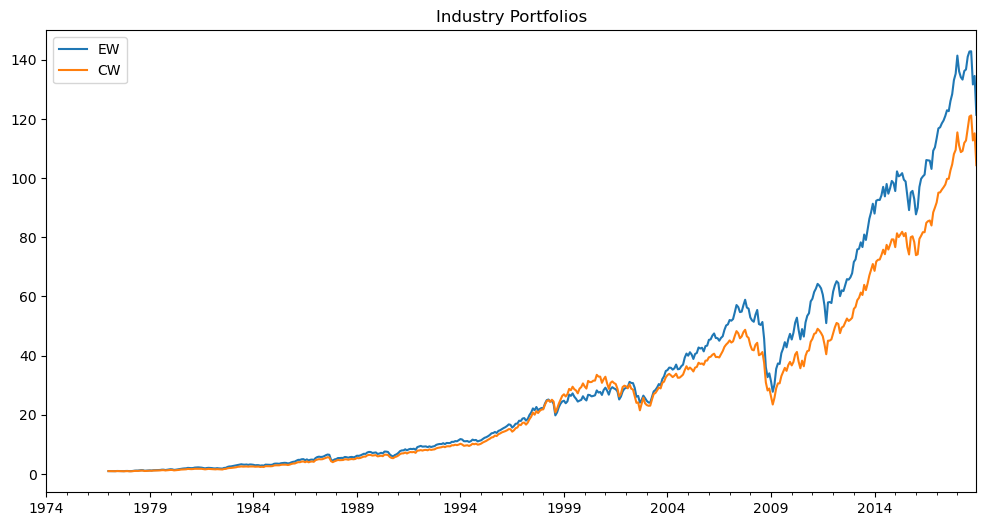

In [8]:
ewr = Backtester(EquallyWeighted(), estimation_window=36).\
                run(ind_rets)
cwr = Backtester(CapWeighted(cap_weights=ind_mcap), estimation_window=36).\
                run(ind_rets)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

In [7]:
mv_erc_r = Backtester(EqualRiskContribution(cov_estimator="sample_cov"), estimation_window=36).\
                                            run(ind_rets)

<Axes: title={'center': 'Industry Portfolios'}>

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.121052,0.161000,-0.769256,6.572680,0.071993,0.103950,0.550248,-0.528292
CW,0.117028,0.149425,-0.703895,5.444447,0.066769,0.096505,0.566698,-0.518418
ERC-Sample,0.120185,0.149185,-0.872577,7.019237,0.066886,0.096357,0.588203,-0.502950


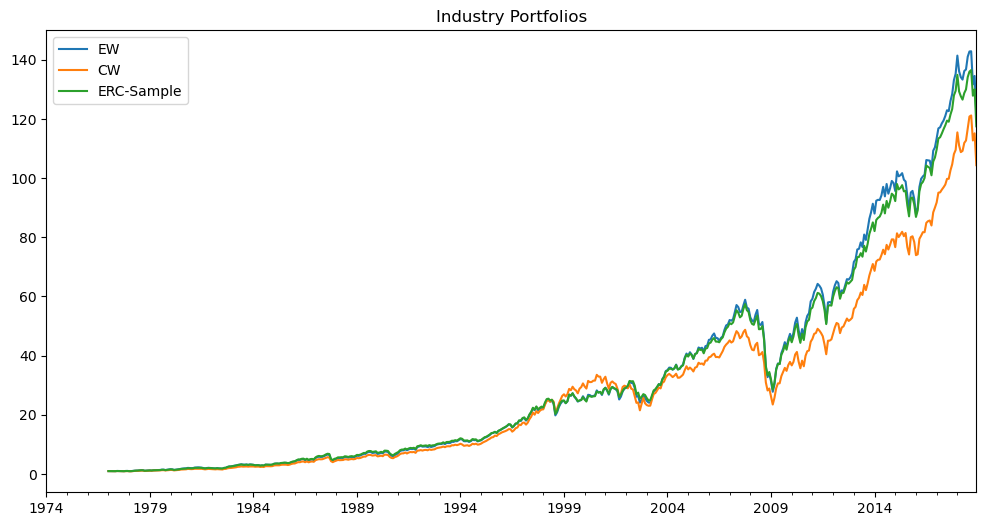

In [9]:
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "ERC-Sample": mv_erc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())